# Fraud Dectection model using sample data

This notebook was built by the data science team to perform exploratory data analysis on sample data, prepare data for training a machine learning model, and train a model. Note that the model performance was inadequate due to the small data sample size and we will need to train the model on a larger dataset to build a successful model.

## Prepare notebook environment

In [6]:
'''
Import necessary packages. This notebook was executed in Colab Enterprise,
but should also work in Vertex AI Workbench.
'''

import numpy as np
import pandas as pd
import sklearn
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import (IntegerLookup, StringLookup,
                                     Discretization, Concatenate, Reshape,
                                     Hashing)


The sample dataset has been placed in an accessible Cloud Storage for all member of our organization. Use `gcloud storage` to download the data to the local environment.

In [3]:
!gcloud storage cp gs://cloud-training/specialized-training/dsl_data/sample_preproc_data/sample_preproc_data-000000000000.csv ./transaction_sample_data.csv
!ls

Copying gs://cloud-training/specialized-training/dsl_data/sample_preproc_data/sample_preproc_data-000000000000.csv to file://./transaction_sample_data.csv

Average throughput: 80.2MiB/s
sample_preproc_data-000000000000.csv  transaction_sample_data.csv


Now load the `transaction_sample_data.csv` file into a Pandas DataFrame for exploration. We will also use this dataframe for preparing the dataset for training our model. To verify that the data was loaded correctly, print the columns of the DataFrame and use the `head` method to print the first 5 rows.

In [7]:
transaction_df = pd.read_csv('transaction_sample_data.csv')
print(transaction_df.columns)
transaction_df.head()

Index(['transactionId', 'step', 'action', 'amount', 'idOrig', 'oldBalanceOrig',
       'newBalanceOrig', 'idDest', 'oldBalanceDest', 'newBalanceDest',
       'isFraud', 'isFlaggedFraud', 'isUnauthorizedOverdraft', 'isSuccessful'],
      dtype='object')


,transactionId,step,action,amount,idOrig,oldBalanceOrig,newBalanceOrig,idDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,isUnauthorizedOverdraft,isSuccessful
0,3965218043302140042,8,CASH_IN,113125.42,4634145719191917,504409.90,617535.32,34-0004077,0.0,0.0,False,False,False,False
1,6433301868915579042,8,CASH_IN,172510.71,4194144307535595,106152.38,278663.09,03-0004474,0.0,0.0,False,False,False,False
2,1236279498399691042,8,CASH_IN,41745.38,4127948271207284,63686.97,105432.35,58-0006829,0.0,0.0,False,False,False,False
3,2033435769800131042,8,CASH_IN,102783.17,4767606703614122,63129.56,165912.72,01-0001723,0.0,0.0,False,False,False,False
4,1222980987545920042,8,CASH_IN,172283.43,4544168127926715,829418.93,1001702.36,91-0003846,0.0,0.0,False,False,False,False


We will not use the `transactionId` field due to it being a unique identifier for each transaction. The `isSuccessful` field was found to be irrelevant and the `isFlaggedFraud` field is from our previous model. We will not use these two fields while training our new model.

In [8]:
transaction_df.drop(columns=['transactionId', 'isSuccessful', 'isFlaggedFraud'], inplace=True)

Now we should check the data types of each column of the DataFrame to ensure that the types are correct. Pandas infers the data types from the first few rows of the DataFrame.

In [10]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35162 entries, 0 to 35161
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   step                     35162 non-null  int64  
 1   action                   35162 non-null  object 
 2   amount                   35162 non-null  float64
 3   idOrig                   35162 non-null  int64  
 4   oldBalanceOrig           35162 non-null  float64
 5   newBalanceOrig           35162 non-null  float64
 6   idDest                   35162 non-null  object 
 7   oldBalanceDest           35162 non-null  float64
 8   newBalanceDest           35162 non-null  float64
 9   isFraud                  35162 non-null  bool   
 10  isUnauthorizedOverdraft  35162 non-null  bool   
dtypes: bool(2), float64(5), int64(2), object(2)
memory usage: 2.5+ MB


The `idOrig` field should be treated as an `object` field and not a `float64` field. Otherwise the fields look like they have the correct types. Let's set the types of the `action`, `idOrig`, and `idDest` fields as `str` for the sake of consistency and explore the descriptive statistics for these fields.


In [15]:
cols = ['action', 'idOrig', 'idDest']
for col in cols:
  transaction_df[col] = transaction_df[col].astype('str', copy=False)
transaction_df[cols].describe()

,action,idOrig,idDest
count,35162,35162,35162
unique,5,27876,31838
top,CASH_IN,4481647121519985,B23-0007186
freq,14603,133,106


There are 5 different types of actions in our sample dataset, we'll explore these later. There are a lot of different values for `idOrig` and `idDest`, so we want to be careful how we treat these features not to run into high-dimensionality issues.

Now let's look at the numeric features.

In [16]:
transaction_df.describe()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
count,35162.000000,3.516200e+04,3.516200e+04,3.516200e+04,3.516200e+04,3.516200e+04
mean,220.005091,1.431921e+05,3.321340e+06,3.301829e+06,3.385342e+05,3.867750e+05
std,646.957836,3.090266e+05,1.960542e+06,1.924417e+06,1.178416e+06,1.346283e+06
min,1.000000,1.500000e-01,-1.382708e+05,-9.760091e+04,-1.901728e+04,0.000000e+00
25%,44.000000,1.321279e+04,2.428366e+06,2.423224e+06,1.792912e+04,2.042542e+04
50%,187.000000,9.365195e+04,3.391560e+06,3.367151e+06,8.146003e+04,8.453358e+04
75%,282.000000,1.703791e+05,4.167476e+06,4.138506e+06,1.777362e+05,1.812265e+05
max,17201.000000,1.097397e+07,5.023783e+07,5.045982e+07,2.811845e+07,2.887887e+07


The range of values for the fields other than `step` have fairly large value ranges with different value distributions. This can cause issues with the convergence of our model due to having to deal with larger values in gradient computations and the correspoding curvature of the loss surface.

To address this, we will normalize the values for the numeric fields.

In [18]:
def standardize(column):
    return (column - column.mean()) / column.std()

std_cols = ['amount',	'oldBalanceOrig',	'newBalanceOrig',
            'oldBalanceDest',	'newBalanceDest']

transaction_df[std_cols] = transaction_df[std_cols].apply(standardize)

transaction_df.describe()


,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
count,35162.000000,3.516200e+04,3.516200e+04,3.516200e+04,3.516200e+04,3.516200e+04
mean,220.005091,-7.759752e-17,5.496491e-17,1.176087e-16,-2.586584e-17,2.586584e-17
std,646.957836,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,1.000000,-4.633647e-01,-1.764619e+00,-1.766473e+00,-3.034171e-01,-2.872910e-01
25%,44.000000,-4.206090e-01,-4.554726e-01,-4.565567e-01,-2.720645e-01,-2.721193e-01
50%,187.000000,-1.603105e-01,3.581699e-02,3.394343e-02,-2.181524e-01,-2.245006e-01
75%,282.000000,8.797604e-02,4.315830e-01,4.347690e-01,-1.364527e-01,-1.526785e-01
max,17201.000000,3.504803e+01,2.393037e+01,2.450508e+01,2.357396e+01,2.116353e+01


Before starting to build a model, let's explore the distribution of some features. First let's look at the distribution of fradulent transactions.

<Axes: xlabel='action'>

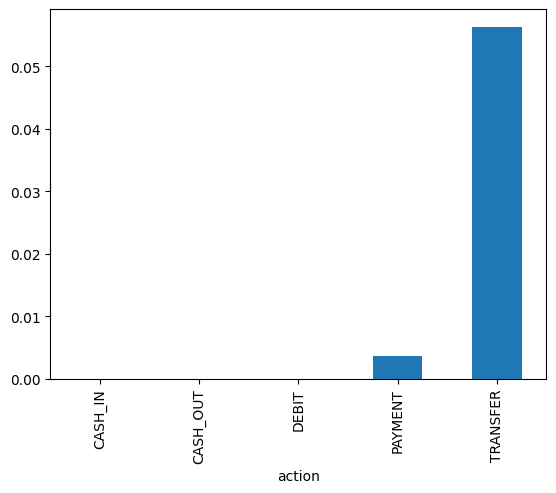

In [19]:
transaction_df.groupby('action')['isFraud'].mean().plot.bar()

This is a bit worrisome. Only 2 types of transactions are possible fradulent. This is likely not representative of the entire dataset, but unfortunately we do not have access to more data at this time.

Now let's look at the proportion of legitmate to fraudulent transactions in the sample dataset.

In [20]:
transaction_df.groupby('action')['isFraud'].value_counts()

action    isFraud
CASH_IN   False      14603
CASH_OUT  False       8314
DEBIT     False       1718
PAYMENT   False       8276
          True          31
TRANSFER  False       2095
          True         125
Name: count, dtype: int64

For the `PAYMENT` and `TRANSFER` values, we see different proportions. The `TRANSFER` value has a higher ratio of fraudulent transactions than the `PAYMENT` value.

Now let us explore the relationship between the different numeric fields and the percentage of fraudulent transactions.

<ipython-input-22-463205bf702b>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  transaction_df.groupby('amountBkts')['isFraud'].mean().plot.bar()


<Axes: xlabel='amountBkts'>

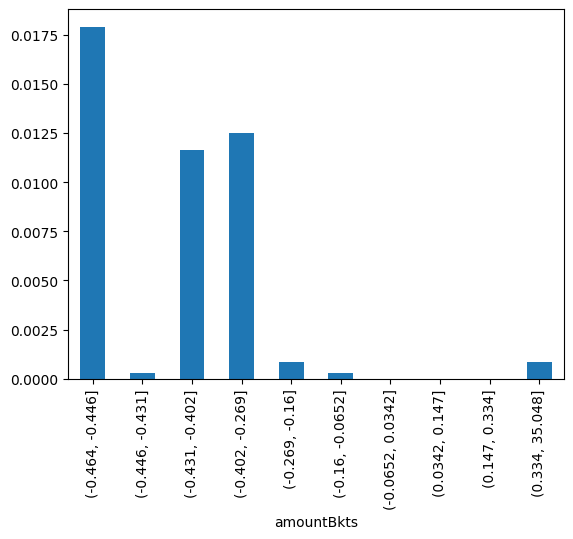

In [22]:
transaction_df['amountBkts'] = pd.qcut(transaction_df['amount'], 10)
transaction_df.groupby('amountBkts')['isFraud'].mean().plot.bar()

<ipython-input-23-ed30cb199188>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  transaction_df.groupby('oldBalanceOrigBkts')['isFraud'].mean().plot.bar()


<Axes: xlabel='oldBalanceOrigBkts'>

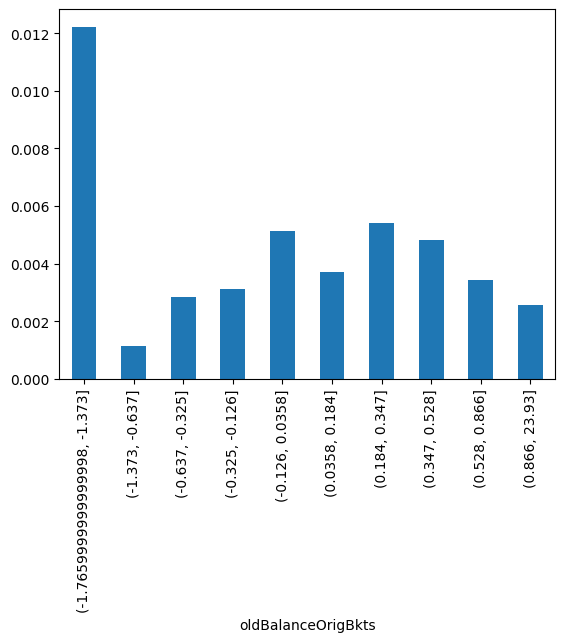

In [23]:
transaction_df['oldBalanceOrigBkts'] = pd.qcut(transaction_df['oldBalanceOrig'], 10,
                        duplicates='drop')
transaction_df.groupby('oldBalanceOrigBkts')['isFraud'].mean().plot.bar()

<ipython-input-24-0a8ea51ad722>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  transaction_df.groupby('newBalanceOrigBkts')['isFraud'].mean().plot.bar()


<Axes: xlabel='newBalanceOrigBkts'>

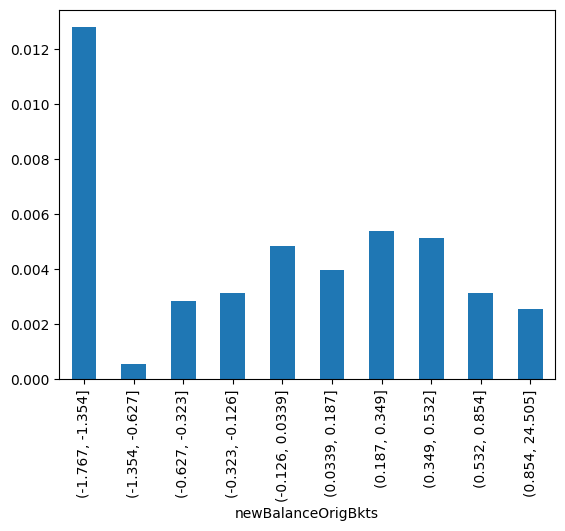

In [24]:
transaction_df['newBalanceOrigBkts'] = pd.qcut(transaction_df['newBalanceOrig'], 10,
                                              duplicates='drop')
transaction_df.groupby('newBalanceOrigBkts')['isFraud'].mean().plot.bar()

<ipython-input-25-62c063f0feee>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  transaction_df.groupby('newBalanceDestBkts')['isFraud'].mean().plot.bar()


<Axes: xlabel='newBalanceDestBkts'>

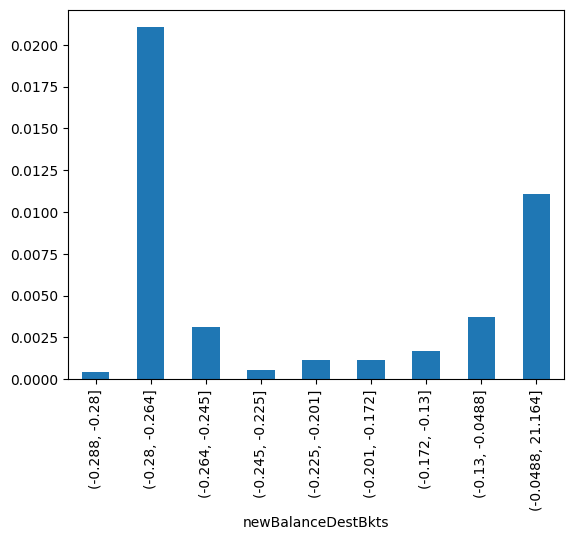

In [25]:
transaction_df['newBalanceDestBkts'] = pd.qcut(transaction_df['newBalanceDest'], 10,
                                              duplicates='drop')
transaction_df.groupby('newBalanceDestBkts')['isFraud'].mean().plot.bar()

<ipython-input-26-62c063f0feee>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  transaction_df.groupby('newBalanceDestBkts')['isFraud'].mean().plot.bar()


<Axes: xlabel='newBalanceDestBkts'>

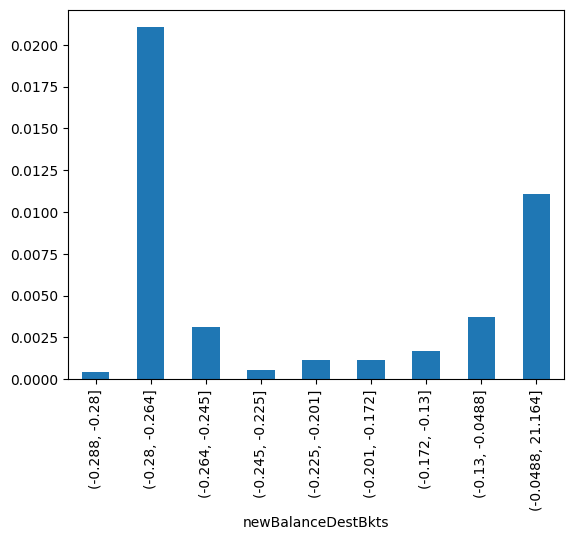

In [26]:
transaction_df['newBalanceDestBkts'] = pd.qcut(transaction_df['newBalanceDest'], 10,
                                              duplicates='drop')
transaction_df.groupby('newBalanceDestBkts')['isFraud'].mean().plot.bar()

There's not a clear linear relationship, but there is some sort of relationship. This is a good indicator that we want to bucketize the numeric columns. Let's remove the `_Bkts` columns we created since we can use Keras to create the bucketized columns more directly later.

In [27]:
for col in ['amountBkts', 'oldBalanceOrigBkts',
            'newBalanceOrigBkts', 'newBalanceDestBkts']:
  transaction_df.pop(col)

We will now split the data into training, validation and test datasets. We will split the data into 80% training, 10% validation and 10% testing.



In [28]:
from sklearn.model_selection import train_test_split

y = transaction_df.pop('isFraud').astype(int)

X_train, X_r, y_train, y_r = train_test_split(transaction_df, y, test_size=0.2)
X_eval, X_test, y_eval, y_test = train_test_split(X_r, y_r, test_size=0.5)

Create the inputs for the Keras model and pack them into a dictionary.

In [30]:
num_cols = ['oldBalanceOrig', 'newBalanceOrig', 'amount',
            'oldBalanceDest', 'newBalanceDest','isUnauthorizedOverdraft','step']
cat_cols = ['action', 'idOrig', 'idDest']

inputs = {}

for col in cat_cols:
  inputs[col] = tf.keras.Input(shape=(1,), name=col,
                               dtype = tf.string)

for col in num_cols:
  inputs[col] = tf.keras.Input(shape=(1,), name=col, dtype = tf.int64)

inputs

{'action': <KerasTensor shape=(None, 1), dtype=string, sparse=None, name=action>,
 'idOrig': <KerasTensor shape=(None, 1), dtype=string, sparse=None, name=idOrig>,
 'idDest': <KerasTensor shape=(None, 1), dtype=string, sparse=None, name=idDest>,
 'oldBalanceOrig': <KerasTensor shape=(None, 1), dtype=int64, sparse=None, name=oldBalanceOrig>,
 'newBalanceOrig': <KerasTensor shape=(None, 1), dtype=int64, sparse=None, name=newBalanceOrig>,
 'amount': <KerasTensor shape=(None, 1), dtype=int64, sparse=None, name=amount>,
 'oldBalanceDest': <KerasTensor shape=(None, 1), dtype=int64, sparse=None, name=oldBalanceDest>,
 'newBalanceDest': <KerasTensor shape=(None, 1), dtype=int64, sparse=None, name=newBalanceDest>,
 'isUnauthorizedOverdraft': <KerasTensor shape=(None, 1), dtype=int64, sparse=None, name=isUnauthorizedOverdraft>,
 'step': <KerasTensor shape=(None, 1), dtype=int64, sparse=None, name=step>}

Create the preprocessed layers and pack them into a dictionary.

In [31]:
preproc_layers = {}

for col in cat_cols:
  if col == 'action':
    layer = StringLookup(output_mode='one_hot')
    layer.adapt(X_train[col])
  elif type(X_train[col].dtype) == np.dtypes.ObjectDType:
    layer = Hashing(100, output_mode='one_hot')
  elif type(X_train[col].dtype) == np.dtypes.Int64DType:
    layer = IntegerLookup(output_mode='one_hot')
    layer.adapt(X_train[col])
  preproc_layers[col] = layer(inputs[col])

for col in ['oldBalanceOrig', 'newBalanceOrig', 'amount',
            'oldBalanceDest', 'newBalanceDest']:
  # layer = Discretization(num_bins=10,
  #                        output_mode='one_hot')
  # layer.adapt(X_train[col])
  preproc_layers[col] = inputs[col]

preproc_layers['isUnauthorizedDraft'] = inputs['isUnauthorizedOverdraft']

preproc_layers

{'action': <KerasTensor shape=(None, 6), dtype=float32, sparse=False, name=keras_tensor>,
 'idOrig': <KerasTensor shape=(None, 100), dtype=float32, sparse=False, name=keras_tensor_1>,
 'idDest': <KerasTensor shape=(None, 100), dtype=float32, sparse=False, name=keras_tensor_2>,
 'oldBalanceOrig': <KerasTensor shape=(None, 1), dtype=int64, sparse=None, name=oldBalanceOrig>,
 'newBalanceOrig': <KerasTensor shape=(None, 1), dtype=int64, sparse=None, name=newBalanceOrig>,
 'amount': <KerasTensor shape=(None, 1), dtype=int64, sparse=None, name=amount>,
 'oldBalanceDest': <KerasTensor shape=(None, 1), dtype=int64, sparse=None, name=oldBalanceDest>,
 'newBalanceDest': <KerasTensor shape=(None, 1), dtype=int64, sparse=None, name=newBalanceDest>,
 'isUnauthorizedDraft': <KerasTensor shape=(None, 1), dtype=int64, sparse=None, name=isUnauthorizedOverdraft>}

Create a candidate model architecture and train the model.

In [32]:
prepared_layer = Concatenate()(list(preproc_layers.values()))

In [33]:
hid_1 = tf.keras.layers.Dense(32, activation='relu')(prepared_layer)
hid_2 = tf.keras.layers.Dense(16, activation='relu')(hid_1)
embedding = tf.keras.layers.Dense(10, activation='relu')(hid_2)
hid_3 = tf.keras.layers.Dense(16, activation='relu')(embedding)
hid_4 = tf.keras.layers.Dense(32, activation='relu')(hid_3)
decoded = tf.keras.layers.Dense(212, activation='linear')(hid_4)

dnn_input = Concatenate()([decoded, prepared_layer])
hid_5 = tf.keras.layers.Dense(32, activation='relu')(dnn_input)
hid_6 = tf.keras.layers.Dense(16, activation='relu')(hid_5)
output = tf.keras.layers.Dense(1, activation='sigmoid')(hid_6)

metrics = [tf.keras.metrics.BinaryAccuracy(),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.AUC(curve='PR')]

model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True), metrics=metrics)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ action (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ idOrig (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ idDest (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ string_lookup             │ (None, 6)              │              0 │ action[0][0]           │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ hashing (Hashing)         │ (None, 100)            │              0 │ idOrig[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ hashing_1 (Hashing)       │ (None, 100)            │              0 │ idDest[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ oldBalanceOrig            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ newBalanceOrig            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ amount (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ oldBalanceDest            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ newBalanceDest            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ isUnauthorizedOverdraft   │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 212)            │              0 │ string_lookup[0][0],   │
│                           │                        │                │ hashing[0][0],         │
│                           │                        │                │ hashing_1[0][0],       │
│                           │                        │                │ oldBalanceOrig[0][0],  │
│                           │                        │                │ newBalanceOrig[0][0],  │
│                           │                        │                │ amount[0][0],          │
│                           │                        │                │ oldBalanceDest[0][0],  │
│                           │                        │                │ newBalanceDest[0][0],  │
│                      

 Total params: 29,375 (114.75 KB)

 Trainable params: 29,375 (114.75 KB)

 Non-trainable params: 0 (0.00 B)

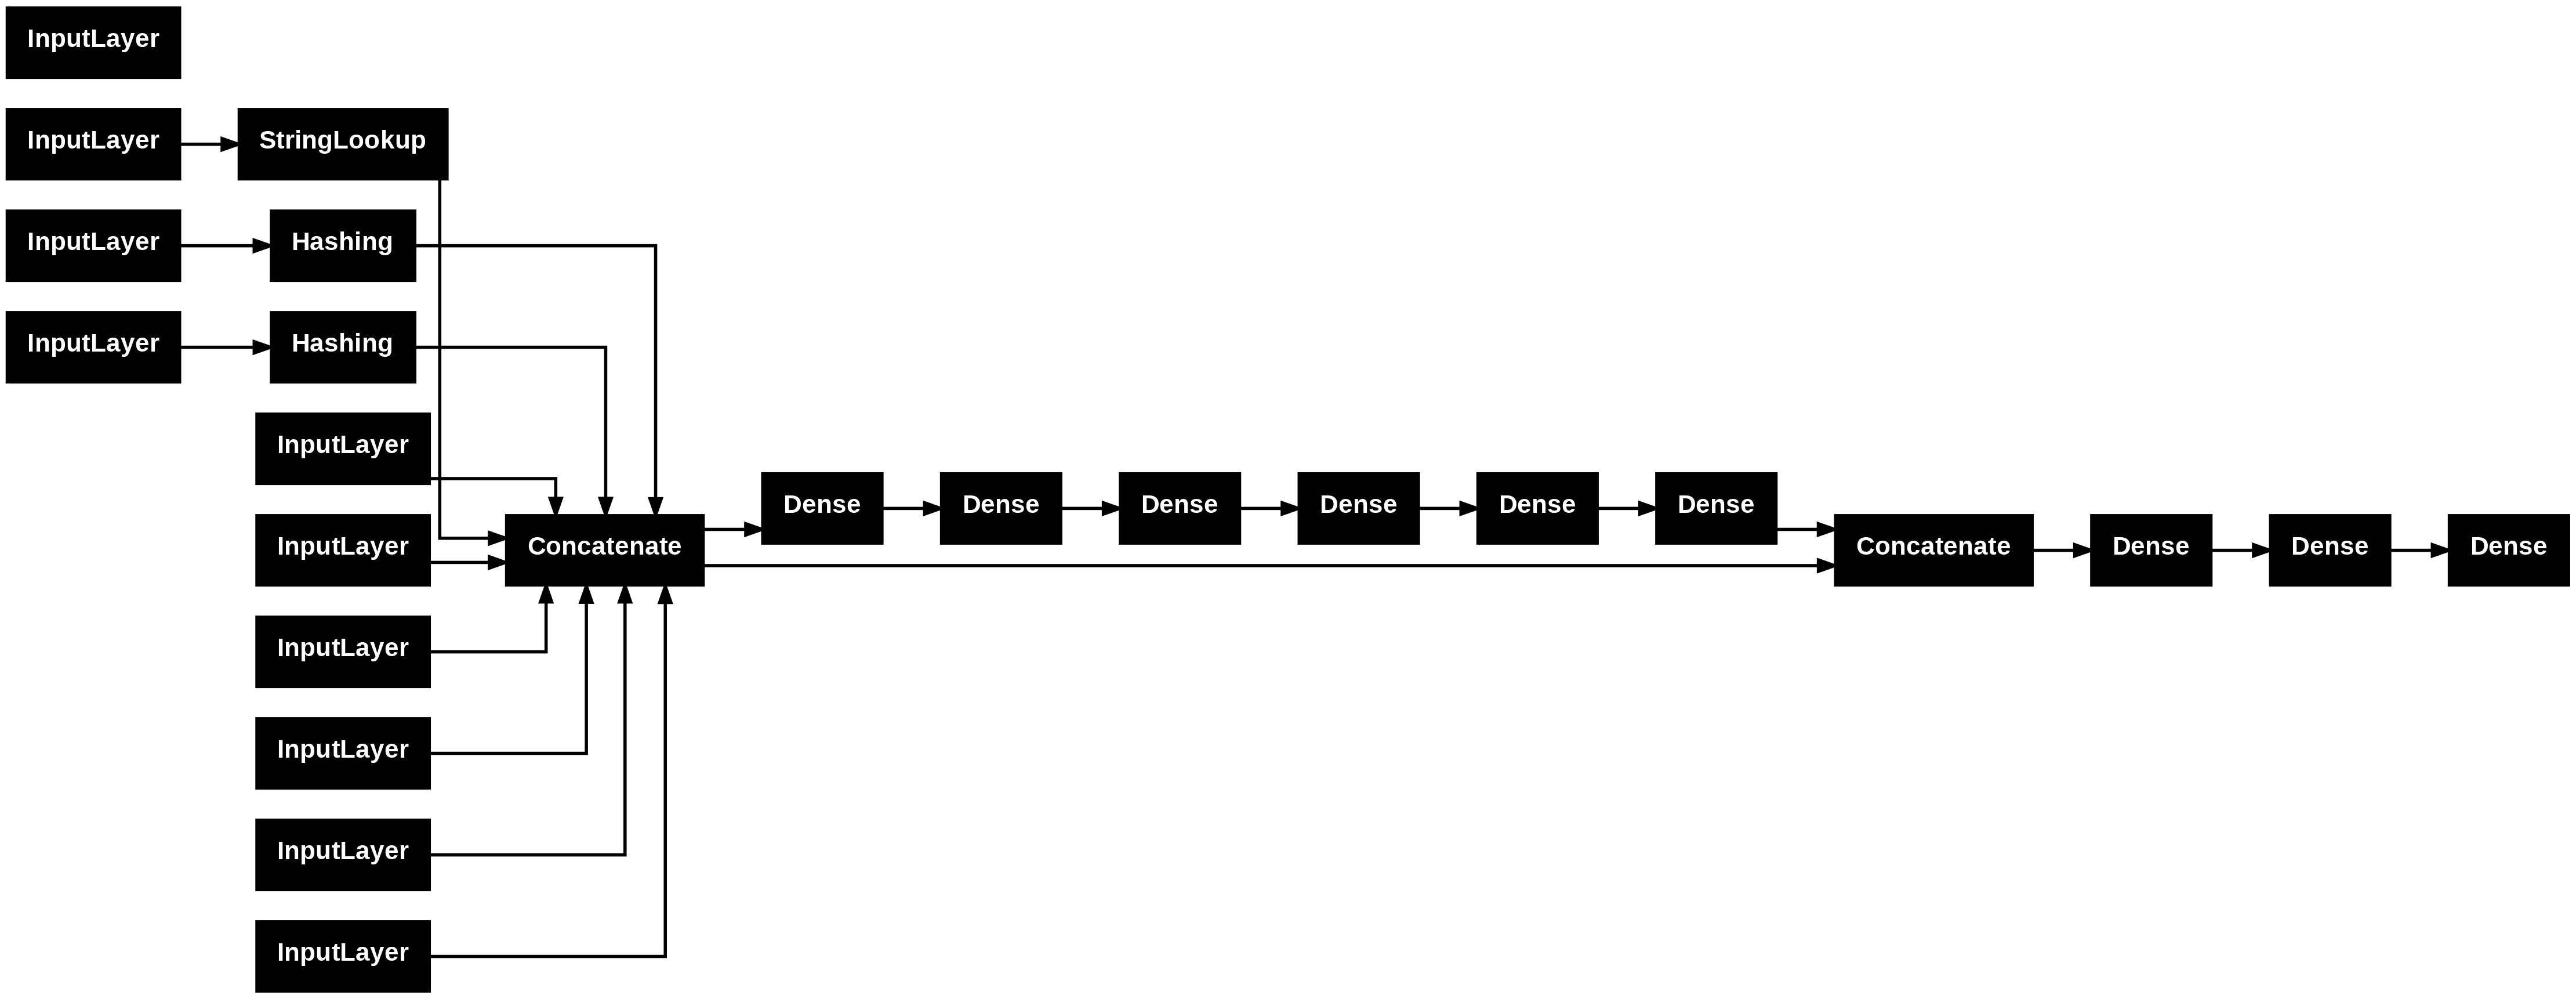

In [34]:
tf.keras.utils.plot_model(model, rankdir="LR")

In [35]:
train_ds = tf.data.Dataset.from_tensor_slices((dict(X_train), y_train)).batch(100)
valid_ds = tf.data.Dataset.from_tensor_slices((dict(X_eval), y_eval)).batch(1000)

history = model.fit(
    x=train_ds,
    epochs=25,
    verbose=1
)

model.evaluate(x=valid_ds)

Epoch 1/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - auc: 0.0068 - binary_accuracy: 0.9480 - loss: 0.0236 - precision: 0.0037 - recall: 0.0532
Epoch 2/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.3022 - binary_accuracy: 0.9962 - loss: 0.0014 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.3831 - binary_accuracy: 0.9962 - loss: 0.0012 - precision: 0.3619 - recall: 0.0106
Epoch 4/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.4512 - binary_accuracy: 0.9962 - loss: 0.0011 - precision: 0.4153 - recall: 0.0230
Epoch 5/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.4975 - binary_accuracy: 0.9966 - loss: 0.0011 - precision: 0.8015 - recall: 0.1276
Epoch 6/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.5458 - binary_accuracy: 0.9967 - loss: 0.0010 - precision: 0.8294 - recall: 0.1707
Epoch 7/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.5773 - binary_accuracy: 0.9969 - loss: 9.5771e-04 - precision: 0.82

[0.0017144418088719249,
 0.996302604675293,
 0.5625,
 0.6000000238418579,
 0.636036217212677]

In [ ]:
model.export('./model')

Saved artifact at './model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 1), dtype=tf.string, name='action'), TensorSpec(shape=(None, 1), dtype=tf.int64, name='amount'), TensorSpec(shape=(None, 1), dtype=tf.string, name='idDest'), TensorSpec(shape=(None, 1), dtype=tf.string, name='idOrig'), TensorSpec(shape=(None, 1), dtype=tf.int64, name='isUnauthorizedOverdraft'), TensorSpec(shape=(None, 1), dtype=tf.int64, name='newBalanceDest'), TensorSpec(shape=(None, 1), dtype=tf.int64, name='newBalanceOrig'), TensorSpec(shape=(None, 1), dtype=tf.int64, name='oldBalanceDest'), TensorSpec(shape=(None, 1), dtype=tf.int64, name='oldBalanceOrig'), TensorSpec(shape=(None, 1), dtype=tf.int64, name='step')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136284427722368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136284427723952: TensorSpec(shape=(), dtype=tf.int64, name=None)
  13628740